In [8]:
import os
import random
import pandas as pd
import numpy as np
from pprint import pprint
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix
from scipy.stats import spearmanr
import itertools
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import shap 
import seaborn as sns
from sklearn.linear_model import LinearRegression
sns.set_style('darkgrid')

# Define file paths

In [2]:
MEASURES_FILE = "60s_MdRQA_measures.csv"
SHUFF_MEASURES_FILE = "60s_shuff_MdRQA_measures.csv"
LABELS_FILE = "Level_Attempts_60s.csv"
RESULTS = "results_binary_classification/" 

TROPHY_RESULTS = RESULTS + "trophy/"

# SUBJ_OUTCOME_RESULTS = RESULTS + "subjective_outcome/"
# VALENCE_RESULTS = RESULTS + "valence/"

# Load data

In [3]:
dfMeasures = pd.read_csv(MEASURES_FILE)
dfShuffMeasures = pd.read_csv(SHUFF_MEASURES_FILE)
dfLabels = pd.read_csv(LABELS_FILE)

print("%s shape: %s" % (MEASURES_FILE, dfMeasures.shape))
print("%s shape: %s" % (SHUFF_MEASURES_FILE, dfShuffMeasures.shape))
print("%s shape: %s" % (LABELS_FILE, dfLabels.shape))


60s_MdRQA_measures.csv shape: (765, 12)
60s_shuff_MdRQA_measures.csv shape: (765, 12)
Level_Attempts_60s.csv shape: (765, 14)


# Helper Functions

In [4]:
features = ['REC', 'DET', 'ADL', 'MDL', 'DENTR', 'LAM', 'AVL', 'MVL', 'VENTR']


def get_group_data(dfData, GROUPID_list, features_list, label_names):
    dfGroupsData = pd.DataFrame()    
    for GROUPID in GROUPID_list:
        dfGroupsData = pd.concat([dfGroupsData, dfData.loc[dfData['GROUPID'] == GROUPID, :]], ignore_index=True)
        
    data = dfGroupsData.loc[:, features_list]  
    labels = dfGroupsData.loc[:, label_names]

    return [data, labels, dfGroupsData]

def min_max_scaling(series):
    # https://datagy.io/pandas-normalize-column/
    return (series - series.min()) / (series.max() - series.min())


def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None,
                          save_fn=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

    if save_fn:
        plt.savefig(save_fn + ".svg", dpi=300, format="svg")
        plt.savefig(save_fn + ".png", dpi=300, format="png")


# Experiment Set Up

In [5]:
# Get model type
shuffled = False
chance = False
num_iters = 1 #25
num_folds = 10
model = "RFC"

if shuffled:
    dfData = pd.merge(dfShuffMeasures, dfLabels, on=['UniqueID', 'GROUPID', 'block'], how='inner')
    # Drop rows with NaN for ADL or AVL
    dfData = dfData.dropna()
elif chance:
    dfData = pd.merge(dfMeasures, dfLabels, on=['UniqueID', 'GROUPID', 'block'], how='inner')
    # Shuffle labels
    label_cols = ['won']
    dfData.loc[:, label_cols] = shuffle(dfData.loc[:, label_cols], random_state=12).reset_index(drop=True)
else:
    dfData = pd.merge(dfMeasures, dfLabels, on=['UniqueID', 'GROUPID', 'block'], how='inner')

print("dfData shape: ", dfData.shape)
display(dfData)


dfData shape:  (765, 23)


,UniqueID,GROUPID,block,REC,DET,ADL,MDL,DENTR,LAM,AVL,...,team,level,relative_start_time,relative_end_time,60_sec_start_time,60_sec_end_time,level_duration,gold_trophy,silver_trophy,won
0,CPS2-ASU-T10-ExpBlock1-278.2048,1010,ExpBlock1,2.076890,44.672131,2.477273,7,5.523857,67.572254,3.012887,...,CPS2-ASU-T10,Fe2,278.2048,900.0020,840,899,621.7972,0,0,0
1,CPS2-ASU-T10-ExpBlock1-49.9987,1010,ExpBlock1,4.769471,68.471148,2.863184,7,6.636032,84.977949,4.009103,...,CPS2-ASU-T10,Green Apple,49.9987,162.0673,93,152,112.0686,0,1,1
2,CPS2-ASU-T10-ExpBlock2-367.5711,1010,ExpBlock2,0.539084,38.947368,2.387097,4,4.097628,49.845201,2.752137,...,CPS2-ASU-T10,Trunk Slide,367.5711,510.6217,441,500,143.0506,0,0,0
3,CPS2-ASU-T10-ExpBlock2-57.1913,1010,ExpBlock2,3.864378,55.286344,2.863118,13,6.129577,78.929766,3.445255,...,CPS2-ASU-T10,Trunk Slide,57.1913,361.1485,292,351,303.9572,0,1,1
4,CPS2-ASU-T10-ExpBlock2-580.5728,1010,ExpBlock2,0.766066,44.444444,2.790698,8,4.361036,60.173697,3.190789,...,CPS2-ASU-T10,Dolphin Show,580.5728,900.0110,840,899,319.4382,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
760,CPS2-CU-T71-ExpBlock2-768.7043,2071,ExpBlock2,1.066818,48.936170,2.520548,5,4.942036,66.110020,3.159624,...,CPS2-CU-T71,Timing is Everything,768.7043,900.0360,840,899,131.3317,0,0,0
761,CPS2-CU-T71-Warmup-324.6296,2071,Warmup,2.936587,52.270531,2.718593,6,5.929228,73.501712,3.308285,...,CPS2-CU-T71,Yippie!,324.6296,447.6709,378,437,123.0413,0,1,1
762,CPS2-CU-T71-Warmup-454.0428,2071,Warmup,3.433111,46.115702,2.374468,6,6.116504,73.678332,2.967016,...,CPS2-CU-T71,Spider Web,454.0428,618.0744,549,608,164.0316,0,1,1
763,CPS2-CU-T71-Warmup-627.1388,2071,Warmup,1.943538,28.759124,2.238636,4,5.150087,49.083130,2.740614,...,CPS2-CU-T71,Annoying Lever,627.1388,900.0090,840,899,272.8702,0,0,0


## Prep for team-level cross validation

In [6]:
# Define fold names
train_folds = []
test_folds = []
set_type = "test"
for j in range(1,num_folds+1): 
    col_name = "Fold" + str(j) + "_" + set_type
    test_folds.append(col_name)
    set_type = "train"  
    col_name = "Fold" + str(j) + "_" + set_type
    train_folds.append(col_name)
    set_type = "test"

folds_dict_list = []

# use dfLabels to match the same folds as the CNN models
teams = pd.unique(dfLabels.GROUPID)

# For every iteration
for i in range(1,num_iters+1):
    print("Iteration: ", i)
    teams = shuffle(teams, random_state=i)
    groups = np.array_split(teams, num_folds)
    
    # Define groups for each fold
    fold_groups = {}
    for j, (train_fold, test_fold) in enumerate(zip(train_folds, test_folds)):
        # make the current group the test group
        fold_groups[test_fold] = groups[j]
        # make all other groups the train group
        train_group = groups[:j] + groups[j+1:]
        train_group = [team for group in train_group for team in group]
        fold_groups[train_fold] = train_group
        
    ## Confirm that for each fold, there is no team overlap bewteen train and test set
    for j in range(1,num_folds+1):
        assert set(fold_groups['Fold'+str(j)+'_test']).isdisjoint(set(fold_groups['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
    print("* No team overlap *")

      
    # Add fold groups to dictionary
    folds_dict_list.append(fold_groups)
    

# Informational
print("\nNumber of iterations: ", len(folds_dict_list))

print("\nIterating through folds_dict_list to check for overlap...")
for i,dicti in enumerate(folds_dict_list):
    for j in range(1,num_folds+1):
        assert set(dicti['Fold'+str(j)+'_test']).isdisjoint(set(dicti['Fold'+str(j)+'_train'])), "There is overlap in train and test set " + str(j)
    
print("* No team overlap *")  



Iteration:  1
* No team overlap *

Number of iterations:  1

Iterating through folds_dict_list to check for overlap...
* No team overlap *


# Regression

## Predict Trophy (Y/N)

Iteration:  1
AUROC:  0.5516143639282626




The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


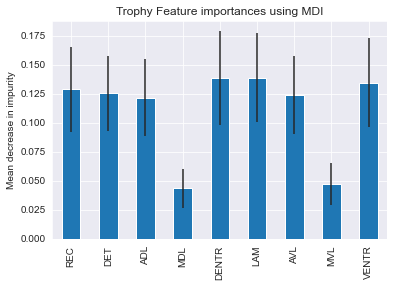


 =========== ALL ITERATIONS RESULTS SUMMARY ===========


,iteration,accuracy,auroc,precision,recall
0,1,0.546405,0.551614,0.567506,0.610837


Averages over all iterations: 
      AUROC: 0.55
  Precision: 0.57
     Recall: 0.61
   Accuracy: 0.55

Median iteration number:  1

Median AUROC: 0.55


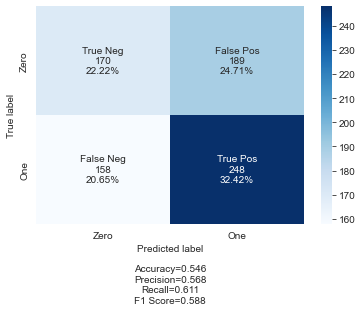

In [14]:
# Resources
## https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Store metrics for all iterations
aurocs = []
precision = []
recall = []
accuracy = []

all_y_test_trophy = [[] for i in range(num_iters)]
predictions_trophy = [[] for i in range(num_iters)]
predict_proba_trophy = [[] for i in range(num_iters)]

# Store feature importances and std dev for all iterations
impurity_importances_trophy = pd.DataFrame(columns=features)
importances_std_trophy = pd.DataFrame(columns=features)

# For storing shap values across all folds
trophy_shap_values_0 = None
trophy_shap_values_1 = None
trophy_full_X_test = pd.DataFrame()

#-----------------------------------------------#
#      5-fold team level cross-validation       #
#-----------------------------------------------#

# For each iteration 
for i in range(num_iters):
    print("Iteration: ", i+1)
    
    # Lists for cumulative test set and predictions for iteration
    dfFullTest = pd.DataFrame()
    all_y_test = []
    predictions = []
    predict_proba = []
    
    # Create model for trophy prediction
    if model == "RFC":
        model_trophy = RandomForestClassifier(random_state=1, max_features='sqrt', \
                                              n_estimators=1600)  # Best 3
# Orig:   RandomForestClassifier(n_estimators=100, random_state=1, max_features='sqrt')
# Best 1: RandomForestClassifier(random_state=1, bootstrap=True, max_depth=10, max_features='sqrt', \
#                                               min_samples_leaf=4, min_samples_split=2, n_estimators=1600)  
# Best 2: RandomForestClassifier(random_state=1, bootstrap=False, max_depth=10, max_features='sqrt', \
#                                               min_samples_leaf=4, min_samples_split=2, n_estimators=1600) 
    
    # Get fold groups
    fold_groups = folds_dict_list[i]
    
    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
#         print("\tFold: ", j+1)
        # Get data for teams in test set
        test_data_list = get_group_data(dfData, fold_groups[test_fold], features, 'won')
        X_test = test_data_list[0]
        y_test = test_data_list[1]
        all_y_test.extend(y_test.tolist())

        dfFullTest = pd.concat([dfFullTest, test_data_list[2]], ignore_index=True)      
        
        # Get data for teams in train set
        train_data_list = get_group_data(dfData, fold_groups[train_fold], features, 'won')
        X_train = train_data_list[0]
        y_train = train_data_list[1]

        # Train model
        model_trophy.fit(X_train, y_train)

        # Test model
        y_pred = model_trophy.predict(X_test)
        predictions.extend(y_pred.tolist())

        y_pp = model_trophy.predict_proba(X_test)[:, 1]
        predict_proba.extend(y_pp.tolist())
        
#         ## Get SHAP values
#         explainer = shap.TreeExplainer(model_trophy)
#         shap_values = explainer.shap_values(X_test)
        
#         if j==0:
#             trophy_shap_values_0 = shap_values[0]
#             trophy_shap_values_1 = shap_values[1]
#         else:
#             trophy_shap_values_0 = np.vstack([trophy_shap_values_0, shap_values[0]])
#             trophy_shap_values_1 = np.vstack([trophy_shap_values_1, shap_values[1]])
#         trophy__full_X_test = pd.concat([trophy__full_X_test, X_test], ignore_index=True)
#         ## End of get SHAP values

# ----- END OF FOLDS


    all_y_test = np.array(all_y_test)
    all_y_test_trophy[i] = all_y_test

    predictions = np.array(predictions)
    predict_proba = np.array(predict_proba)
    
    predictions_trophy[i] = predictions
    predict_proba_trophy[i] = predict_proba
    
    # Get metrics of iteration
    auroc = roc_auc_score(all_y_test, predict_proba)
    prec = precision_score(all_y_test, predictions)
    rec = recall_score(all_y_test, predictions)
    acc = accuracy_score(all_y_test, predictions)
    
    aurocs.append(auroc)
    precision.append(prec)
    recall.append(rec)
    accuracy.append(acc)
    
    print("AUROC: ", auroc)
    print("\n")
    

    # Save actual labels and predictions for iteration
    dfTruevPred = dfFullTest.loc[:, ['GROUPID', 'block', 'won']]
    dfTruevPred['prediction'] = predictions
    dfTruevPred.sort_values(['GROUPID', 'block', 'won'], ignore_index=True, inplace=True)
           
    if shuffled:
        ACTvPRED_SAVE_DIR = TROPHY_RESULTS + "RAW_SHUFFLED/" + model + "/" + model + "_Trophy_True_vs_Pred_SHUFF_" + str(i+1) + ".csv"
    elif chance:
        ACTvPRED_SAVE_DIR = TROPHY_RESULTS + "RAW_CHANCE/" + model + "/" + model + "_Trophy_True_vs_Pred_CHANCE_" + str(i+1) + ".csv"
    else:
        ACTvPRED_SAVE_DIR = TROPHY_RESULTS + "RAW/" + model + "/" + model + "_Trophy_True_vs_Pred_" + str(i+1) + ".csv"
    dfTruevPred.to_csv(ACTvPRED_SAVE_DIR, index=False)
  
    #-----------------------------------------------#
    #   Compute Feature Importances for iteration   #
    #-----------------------------------------------#
    if model == "RFC":
        importances = model_trophy.feature_importances_
        std = np.std([tree.feature_importances_ for tree in model_trophy.estimators_], axis=0)
        imps = pd.Series(importances, index=features)
        stds = pd.Series(std, index=features)
        impurity_importances_trophy = impurity_importances_trophy.append(imps, ignore_index=True)
        importances_std_trophy = importances_std_trophy.append(stds, ignore_index=True)

        # Plot feature importances
        fig1, ax1 = plt.subplots()
        imps.plot.bar(yerr=std, ax=ax1)
        ax1.set_title("Trophy Feature importances using MDI")
        ax1.set_ylabel("Mean decrease in impurity")
        plt.show()
    
    
# ----- END OF ITERATIONS

print("\n =========== ALL ITERATIONS RESULTS SUMMARY ===========")
dfMetrics = pd.DataFrame({'iteration': [i for i in range(1,num_iters+1)], 'accuracy': accuracy, \
                          'auroc': aurocs, 'precision': precision, 'recall': recall})

display(dfMetrics)

if shuffled:
    METRICS_SAVE_DIR =TROPHY_RESULTS + "RAW_SHUFFLED/" + model + "/" + model + "_Trophy_Metrics_SHUFF.csv"
elif chance:
    METRICS_SAVE_DIR = TROPHY_RESULTS + "RAW_CHANCE/" + model + "/" + model + "_Trophy_Metrics_CHANCE.csv"
else:
    METRICS_SAVE_DIR = TROPHY_RESULTS + "RAW/" + model + "/" + model + "_Trophy_Metrics.csv"
dfMetrics.to_csv(METRICS_SAVE_DIR, index=False)


print("Averages over all iterations: ")
print("%12s %.2f" % ("AUROC:", np.mean(dfMetrics['auroc'])))
print("%12s %.2f" % ("Precision:", np.mean(dfMetrics['precision'])))
print("%12s %.2f" % ("Recall:", np.mean(dfMetrics['recall'])))
print("%12s %.2f" % ("Accuracy:", np.mean(dfMetrics['accuracy'])))

# Get median iterations
med_auroc = np.median(aurocs)
med_auroc_idx = np.argsort(aurocs)[len(aurocs)//2]
med_iter_num = med_auroc_idx+1
med_data = data = [[med_iter_num, med_auroc]]
dfMedian = pd.DataFrame(med_data, columns=['med_iter_num', 'med_auroc'])

if shuffled:
    MEDIAN_SAVE_DIR = TROPHY_RESULTS + "RAW_SHUFFLED/" + model + "/" + model + "_Median_SHUFF.csv"
elif chance:
    MEDIAN_SAVE_DIR = TROPHY_RESULTS + "RAW_CHANCE/" + model + "/" + model + "_Median_CHANCE.csv"
else:
    MEDIAN_SAVE_DIR = TROPHY_RESULTS + "RAW/" + model + "/" + model + "_Median.csv"
dfMedian.to_csv(MEDIAN_SAVE_DIR, index=False) 

print("\nMedian iteration number: ", med_iter_num)
print("\n%6s %.2f" % ("Median AUROC:", np.median(dfMetrics['auroc'])))


# Plot confusion matrix of median iteration
if shuffled:
    CM_SAVE_DIR = TROPHY_RESULTS + "RAW_SHUFFLED/" + model + "/" + model + "_CM_SHUFF"
elif chance:
    CM_SAVE_DIR = TROPHY_RESULTS + "RAW_CHANCE/" + model + "/" + model + "_CM_CHANCE"
else:
    CM_SAVE_DIR = TROPHY_RESULTS + "RAW/" + model + "/" + model + "_CM"

cf_matrix = confusion_matrix(all_y_test_trophy[med_auroc_idx], predictions_trophy[med_auroc_idx])
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Zero', 'One']
make_confusion_matrix(cf_matrix, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',
                      save_fn = CM_SAVE_DIR)


## (LR ONLY) Get linear regression coefficients for the median model

In [ ]:
# TODO
if model == "LR":
    
    i = med_corr_idx # for iteration number 1 (median iteration)
    print("Median iteration number: ", i+1)
    
    # Store metrics for all iterations
    maes = []    # MAE (mean absolute errors)
    mses = []    # MSE (mean squared errors)
    rmses = []   # RMSE (root mean squared errors)
    corrs = []   # spearman correlations
    ps = []      # spearman correlation p-values
    
    # Get fold groups
    fold_groups = folds_dict_list[i]
    
    # For each fold
    for j, (test_fold, train_fold) in enumerate(zip(test_folds, train_folds)):
        print("\tFold: ", j+1)
        # Get data for teams in test set
        if normalize:
            test_data_list = get_group_data(dfData, fold_groups[test_fold], features, 'norm_task_score')
        else:
            test_data_list = get_group_data(dfData, fold_groups[test_fold], features, 'task_score')
        X_test = test_data_list[0]
        y_test = test_data_list[1]      
        
        # Get data for teams in train set
        if normalize:
            train_data_list = get_group_data(dfData, fold_groups[train_fold], features, 'norm_task_score')
        else:
            train_data_list = get_group_data(dfData, fold_groups[train_fold], features, 'task_score')
        X_train = train_data_list[0]
        y_train = train_data_list[1]

        # Train model
        model_task_score.fit(X_train, y_train)

#         coeff_df = pd.DataFrame(model_task_score.coef_, X_train.columns, columns=['Coefficient'])
#         display(coeff_df)
        
        # Test model
        y_pred = model_task_score.predict(X_test)
        
        # Calculate evaluation metrics of the fold
        mae = metrics.mean_absolute_error(y_test, y_pred)
        mse = metrics.mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
        corr, p = spearmanr(y_test, y_pred)
        maes.append(mae)
        mses.append(mse)
        rmses.append(rmse)
        corrs.append(corr)
        ps.append(p)
        
    
    dfMetrics = pd.DataFrame({'fold': [i for i in range(1,len(test_folds)+1)], \
                          'mae': maes, 'mse': mses, 'rmse': rmses, 'corrs': corrs, 'ps': ps})
    
    display(dfMetrics)
    
    
    print("Average over all folds:")
    print("%6s %.2f" % ("MAE:", np.mean(dfMetrics['mae'])))
    print("%6s %.2f" % ("MSE:", np.mean(dfMetrics['mse'])))
    print("%6s %.2f" % ("RMSE:", np.mean(dfMetrics['rmse'])))
    print("%6s %.2f" % ("Corr:", np.mean(dfMetrics['corrs'])))
    print("%6s %.7f" % ("p-val:", np.mean(dfMetrics['ps'])))

    # Get median fold
    med_corr_idx = np.argsort(corrs)[len(corrs)//2]
    print("\nMedian fold number: ", med_corr_idx+1)
    
    
    
print("\n\n***** Now running median fold ......")

fold_idx = med_corr_idx
test_fold = test_folds[fold_idx]
train_fold = train_folds[fold_idx]

print("\tFold: ", fold_idx+1)

# Get data for teams in test set
test_data_list = get_group_data(dfData, fold_groups[test_fold], features, 'task_score')
X_test = test_data_list[0]
y_test = test_data_list[1]      

# Get data for teams in train set
train_data_list = get_group_data(dfData, fold_groups[train_fold], features, 'task_score')
X_train = train_data_list[0]
y_train = train_data_list[1]

# Train model
model_task_score.fit(X_train, y_train)

coeff_df = pd.DataFrame(model_task_score.coef_, X_train.columns, columns=['Coefficient'])
display(coeff_df)


if shuffled:
    coeff_df.to_csv(TASK_SCORE_RESULTS + "RAW_SHUFFLED/" + model + "/" + model + "_Median_iter_fold_LR_coeffs_SHUFF.csv")
elif chance:
    coeff_df.to_csv(TASK_SCORE_RESULTS + "RAW_CHANCE/" + model + "/" + model + "_Median_iter_fold_LR_coeffs_CHANCE.csv")
else:
    coeff_df.to_csv(TASK_SCORE_RESULTS + "RAW/" + model + "/" + model + "_Median_iter_fold_LR_coeffs.csv")

        
        

# Hyperparameter Tuning

## Random Search CV

### Classification

In [11]:
features = ['REC', 'DET', 'ADL', 'MDL', 'DENTR', 'LAM', 'AVL', 'MVL', 'VENTR']

X = dfData.loc[:, features]  
y = dfData.loc[:, 'won']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
print("\n")


## Use the random grid to search for best hyperparameters

# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

pprint(rf_random.best_params_)



base_model = RandomForestClassifier(n_estimators=100, random_state=1, max_features='sqrt') 
base_model.fit(X_train, y_train)
base_predictions = base_model.predict(X_test)

print('Base Model Performance')
print(classification_report(y_test, base_predictions, zero_division=1))


best_random = rf_random.best_estimator_
random_predictions = best_random.predict(X_test)

print('Random Model Performance')
print(classification_report(y_test, random_predictions, zero_division=1))



{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


Fitting 3 folds for each of 100 candidates, totalling 300 fits
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 1600}
Base Model Performance
              precision    recall  f1-score   support

           0       0.52      0.36      0.43        72
           1       0.55      0.70      0.62        81

    accuracy                           0.54       153
   macro avg       0.54      0.53      0.52       153
weighted avg       0.54      0.54      0.53       153

Random Model Performance
              precision    recall  f1-score   support

           0       0.56      0.43      0.49        72
           1       0.58      0.70      0.64